<a href="https://colab.research.google.com/github/kmtsui/SummerProject2021/blob/pwagh/Gaussian_example_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install some packages in order to use latex
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
! apt install cm-super
! pip install latex

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [62.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

In [3]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [4]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.5.0


OmniFold Gaussian Toy Example
Setup the Datasets

In [11]:
mu0 = [0,0]                       #For the synthetic distribution
sigma0 = [[1,0],[0,1]]    

mu_unknown = [3,5]                #For the natural distribution
sigma_unknown = [[1,2],[2,1]]

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true

back = 0.1 #fraction of a background process that we would like to subtract

In [13]:
N = 10**5
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (mu_unknown, sigma_unknown)  # this is the data (the target)
background_param = ([0,0], [[0.2,0],[0,0.2]])  # background
epsilon = 0.5  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.multivariate_normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G)) # truth events that do not pass reco
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # reco events that are not true
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.multivariate_normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background])
theta0_G_withback = np.concatenate([theta0_G,-np.ones((int(N*back),2))*dummyval])

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.multivariate_normal(theta_unknown_param[0],theta_unknown_param[1], N)
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) 
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval

theta_background = np.random.multivariate_normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background])
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones((int(N*back),2))*dummyval])

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: covariance is not positive-semidefinite.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


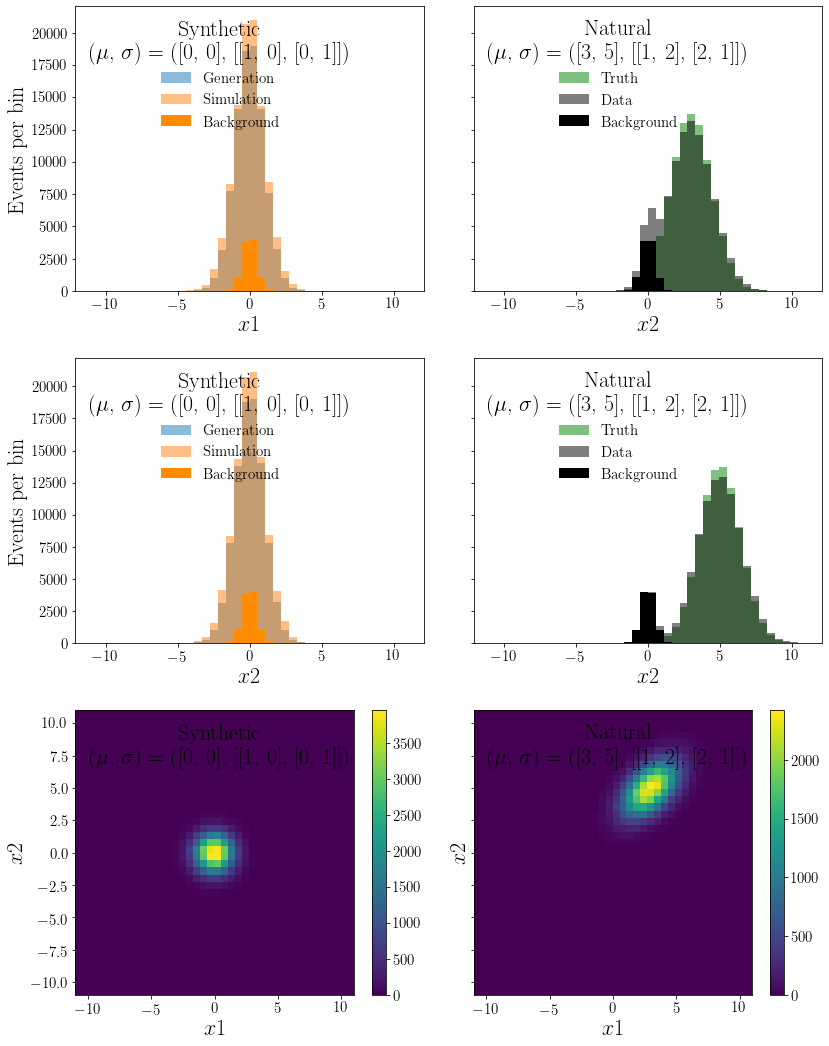

In [14]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(3,
                       2,
                       figsize=(12, 15),
                       #constrained_layout=True,
                       sharey='row')

# plot the x1 and x2 variables
for i in range(2):
        ax[i,0].set_xlabel('$x$'+str(i+1))
        ax[i,0].set_ylabel('Events per bin')
        ax[i,0].hist(theta0_G[theta0_G[:,i]!=dummyval][:,i], bins=bins, **plot_style_2, label='Generation') # This is the MC truth distribution
        ax[i,0].hist(theta0_S_withback[theta0_S_withback[:,i]!=dummyval][:,i], bins=bins, **plot_style_2, label='Simulation') # MC reco distribution with background
        ax[i,0].hist(theta0_S_withback[theta0_G_withback[:,i]==-dummyval][:,i], bins=bins, color="darkorange", label='Background') # MC background prediction
        legend = ax[i,0].legend(
            title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
            loc='upper left',
            frameon=False)
        plt.setp(legend.get_title(), multialignment='center')

        ax[i,1].set_xlabel('$x2$')
        ax[i,1].hist(theta_unknown_G[theta_unknown_G[:,i]!=dummyval][:,i], bins=bins, **plot_style_2, label='Truth',color="green") # Real data truth distribution
        ax[i,1].hist(theta_unknown_S_withback[theta_unknown_S_withback[:,i]!=dummyval][:,i], bins=bins, **plot_style_2, label='Data',color="black") # Real data reco distribution with background
        ax[i,1].hist(theta_unknown_S_withback[theta_unknown_G_withback[:,i]==-dummyval][:,i], bins=bins, label='Background',color="black") # Real data background
        legend = ax[i,1].legend(
            title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
            loc='upper left',
            frameon=False)
        plt.setp(legend.get_title(), multialignment='center')

ax[2,0].set_xlabel('$x1$')
ax[2,0].set_ylabel('$x2$')
h1 = ax[2,0].hist2d(theta0_G[theta0_G[:,0]!=dummyval][:,0], theta0_G[theta0_G[:,1]!=dummyval][:,1] , bins=(bins,bins),label='Generation')
fig.colorbar(h1[3],ax=ax[2,0])
legend = ax[2,0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[2,1].set_xlabel('$x1$')
ax[2,1].set_ylabel('$x2$')
theta0_S_withback_plot1=theta_unknown_S_withback[:,1]
h2 = ax[2,1].hist2d(theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,0], theta_unknown_G[theta_unknown_G[:,1]!=dummyval][:,1] , bins=(bins,bins),label='Truth')
fig.colorbar(h2[3],ax=ax[2,1])
legend = ax[2,1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.tight_layout()

fig.show()

Unfold Data

In [15]:
iterations = 4

In [16]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [17]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

In [18]:
#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.

x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback[:,0]==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback[:,0]==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval]))])

W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback[:,0]==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=200,
          batch_size=10000,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

Epoch 1/200
16/16 [==============================] - 20s 406ms/step - loss: 0.6646 - accuracy: 0.4835 - val_loss: 0.6254 - val_accuracy: 0.4843
Epoch 2/200
16/16 [==============================] - 0s 22ms/step - loss: 0.6256 - accuracy: 0.4793 - val_loss: 0.6192 - val_accuracy: 0.4762
Epoch 3/200
16/16 [==============================] - 0s 22ms/step - loss: 0.6193 - accuracy: 0.4739 - val_loss: 0.6132 - val_accuracy: 0.4755
Epoch 4/200
16/16 [==============================] - 0s 22ms/step - loss: 0.6135 - accuracy: 0.4759 - val_loss: 0.6070 - val_accuracy: 0.4771
Epoch 5/200
16/16 [==============================] - 0s 23ms/step - loss: 0.6056 - accuracy: 0.4740 - val_loss: 0.6030 - val_accuracy: 0.4763
Epoch 6/200
16/16 [==============================] - 0s 22ms/step - loss: 0.6049 - accuracy: 0.4760 - val_loss: 0.6006 - val_accuracy: 0.4752
Epoch 7/200
16/16 [==============================] - 0s 22ms/step - loss: 0.6046 - accuracy: 0.4784 - val_loss: 0.5992 - val_accuracy: 0.4779
Epoc

In [19]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


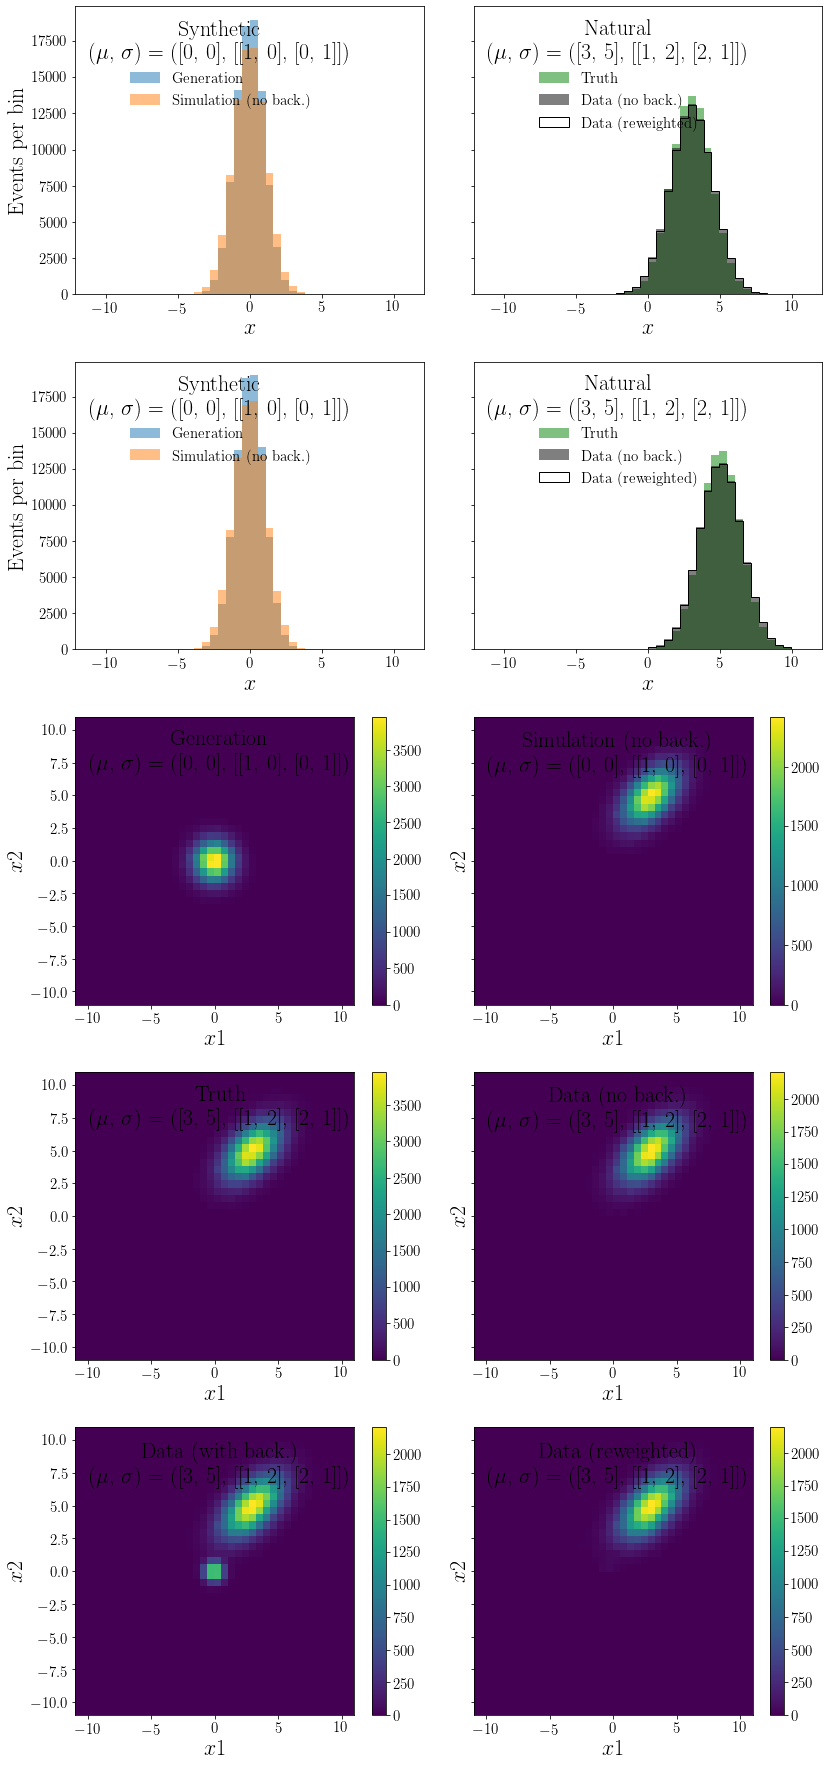

In [20]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(5,
                       2,
                       figsize=(12, 25),
                       #constrained_layout=True,
                       sharey='row')

for i in range(2):
        ax[i,0].set_xlabel('$x$')
        ax[i,0].set_ylabel('Events per bin')
        ax[i,0].hist(theta0_G[theta0_G[:,0]!=dummyval][:,i], bins=bins, **plot_style_2, label='Generation') # MC event at generation
        ax[i,0].hist(theta0_S[theta0_S[:,0]!=dummyval][:,i], bins=bins, **plot_style_2, label='Simulation (no back.)') # MC event after reco
        legend = ax[i,0].legend(
            title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
            loc='upper left',
            frameon=False)
        plt.setp(legend.get_title(), multialignment='center')

        ax[i,1].set_xlabel('$x$')
        ax[i,1].hist(theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,i], bins=bins, **plot_style_2, label='Truth',color="green") # Real event at generation
        ax[i,1].hist(theta_unknown_S[theta_unknown_S[:,0]!=dummyval][:,i], bins=bins, **plot_style_2, label='Data (no back.)',color="black") # Real event after reco
        ax[i,1].hist(theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval][:,i], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data) # Reweighing background-included real reco event to subtract background
        legend = ax[i,1].legend(
            title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
            loc='upper left',
            frameon=False)
        plt.setp(legend.get_title(), multialignment='center')

ax[2,0].set_xlabel('$x1$')
ax[2,0].set_ylabel('$x2$')
h1 = ax[2,0].hist2d(theta0_G[theta0_G[:,0]!=dummyval][:,0], theta0_G[theta0_G[:,0]!=dummyval][:,1] , bins=(bins,bins),label='Generation') # MC event at generation
fig.colorbar(h1[3],ax=ax[2,0])
legend = ax[2,0].legend(
    title='Generation\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[2,1].set_xlabel('$x1$')
ax[2,1].set_ylabel('$x2$')
h2 = ax[2,1].hist2d(theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,0], theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,1] , bins=(bins,bins),label='Simulation (no back.)') # MC event after reco
fig.colorbar(h2[3],ax=ax[2,1])
legend = ax[2,1].legend(
    title='Simulation (no back.)\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[3,0].set_xlabel('$x1$')
ax[3,0].set_ylabel('$x2$')
h3 = ax[3,0].hist2d(theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,0], theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,1] , bins=(bins,bins),label='Truth') # Real event at generation
fig.colorbar(h1[3],ax=ax[3,0])
legend = ax[3,0].legend(
    title='Truth\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[3,1].set_xlabel('$x1$')
ax[3,1].set_ylabel('$x2$')
h4 = ax[3,1].hist2d(theta_unknown_S[theta_unknown_S[:,0]!=dummyval][:,0], theta_unknown_S[theta_unknown_S[:,0]!=dummyval][:,1] , bins=(bins,bins),label='Data (no back.)') # Real event after reco
fig.colorbar(h4[3],ax=ax[3,1])
legend = ax[3,1].legend(
    title='Data (no back.)\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[4,0].set_xlabel('$x1$')
ax[4,0].set_ylabel('$x2$')
h5 = ax[4,0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval][:,0], theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval][:,1] , bins=(bins,bins),label='Data (with back.)') # Real event after reco + background
fig.colorbar(h5[3],ax=ax[4,0])
legend = ax[4,0].legend(
    title='Data (with back.)\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[4,1].set_xlabel('$x1$')
ax[4,1].set_ylabel('$x2$')
h6 = ax[4,1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval][:,0], theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval][:,1] , bins=(bins,bins),label='Data (reweighted)',weights=w_data) # Reweighing background-included real reco event to subtract background
fig.colorbar(h6[3],ax=ax[4,1])
legend = ax[4,1].legend(
    title='Data (reweighted)\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.tight_layout()

fig.show()

In [21]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [22]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback[:,0]!=dummyval]))))

In [23]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, w_data))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1[X_train_1[:,0]!=dummyval], # Classification at reco level
              Y_train_1[X_train_1[:,0]!=dummyval],
              sample_weight=w_train_1[X_train_1[:,0]!=dummyval],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1[:,0]!=dummyval], Y_test_1[X_test_1[:,0]!=dummyval], w_test_1[X_test_1[:,0]!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    
    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    # Training for events that don't pass reco
    xvals_1b = np.concatenate([theta0_G[theta0_S[:,0]!=dummyval],theta0_G[theta0_S[:,0]!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S[:,0]!=dummyval])),np.zeros(len(theta0_G[theta0_S[:,0]!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S[:,0]!=dummyval],np.ones(len(theta0_G[theta0_S[:,0]!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_G[theta0_S[:,0]==dummyval])
    weights_pull[theta0_S[:,0]==dummyval] = average_vals
    ###
    
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=2000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G[:,0]!=dummyval],theta0_S[theta0_G[:,0]!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G[:,0]!=dummyval])),np.zeros(len(theta0_S[theta0_G[:,0]!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G[:,0]!=dummyval],np.ones(len(theta0_S[theta0_G[:,0]!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_S[theta0_G[:,0]==dummyval])
    weights_push[theta0_G[:,0]==dummyval] = average_vals
    ###    
    
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200
15/15 [==============================] - 6s 394ms/step - loss: 0.3281 - accuracy: 0.8423 - val_loss: 0.1699 - val_accuracy: 0.9225
Epoch 2/200
15/15 [==============================] - 0s 21ms/step - loss: 0.1428 - accuracy: 0.9228 - val_loss: 0.0846 - val_accuracy: 0.9237
Epoch 3/200
15/15 [==============================] - 0s 20ms/step - loss: 0.0790 - accuracy: 0.9237 - val_loss: 0.0669 - val_accuracy: 0.9244
Epoch 4/200
15/15 [==============================] - 0s 21ms/step - loss: 0.0668 - accuracy: 0.9236 - val_loss: 0.0632 - val_accuracy: 0.9244
Epoch 5/200
15/15 [==============================] - 0s 22ms/step - loss: 0.0638 - accuracy: 0.9242 - val_loss: 0.0621 - val_accuracy: 0.9243
Epoch 6/200
15/15 [==============================] - 0s 21ms/step - loss: 0.0621 - accuracy: 0.9240 - val_loss: 0.0617 - val_accuracy: 0.9244
Epoch 7/200
15/15 [==============================] - 0s 21ms/step - loss: 0.0629 - accuracy: 0.9234 - val_loss: 0.0611 - val

No handles with labels found to put in legend.
No handles with labels found to put in legend.


ITERATION 1:


No handles with labels found to put in legend.
No handles with labels found to put in legend.


ITERATION 2:


No handles with labels found to put in legend.
No handles with labels found to put in legend.


ITERATION 3:


No handles with labels found to put in legend.
No handles with labels found to put in legend.


ITERATION 4:


No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 864x360 with 0 Axes>

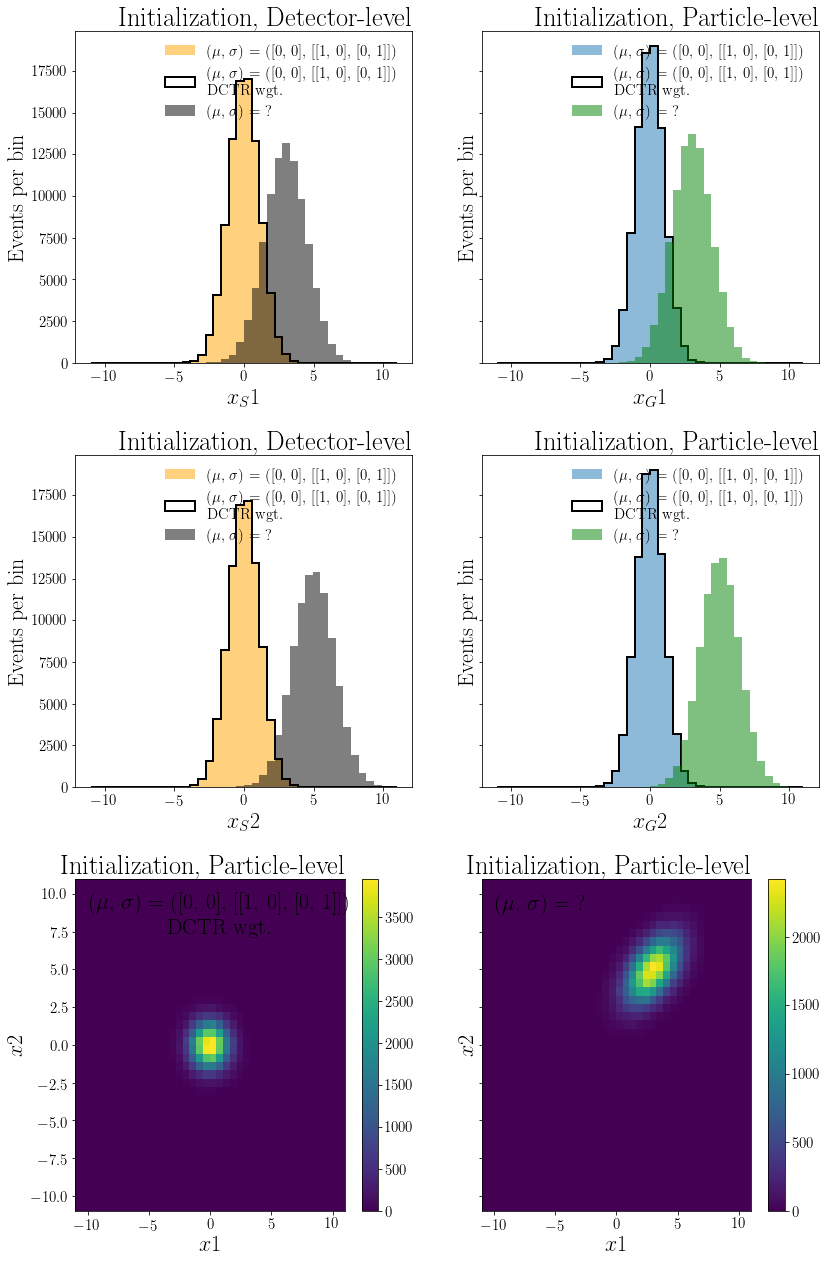

<Figure size 864x288 with 0 Axes>

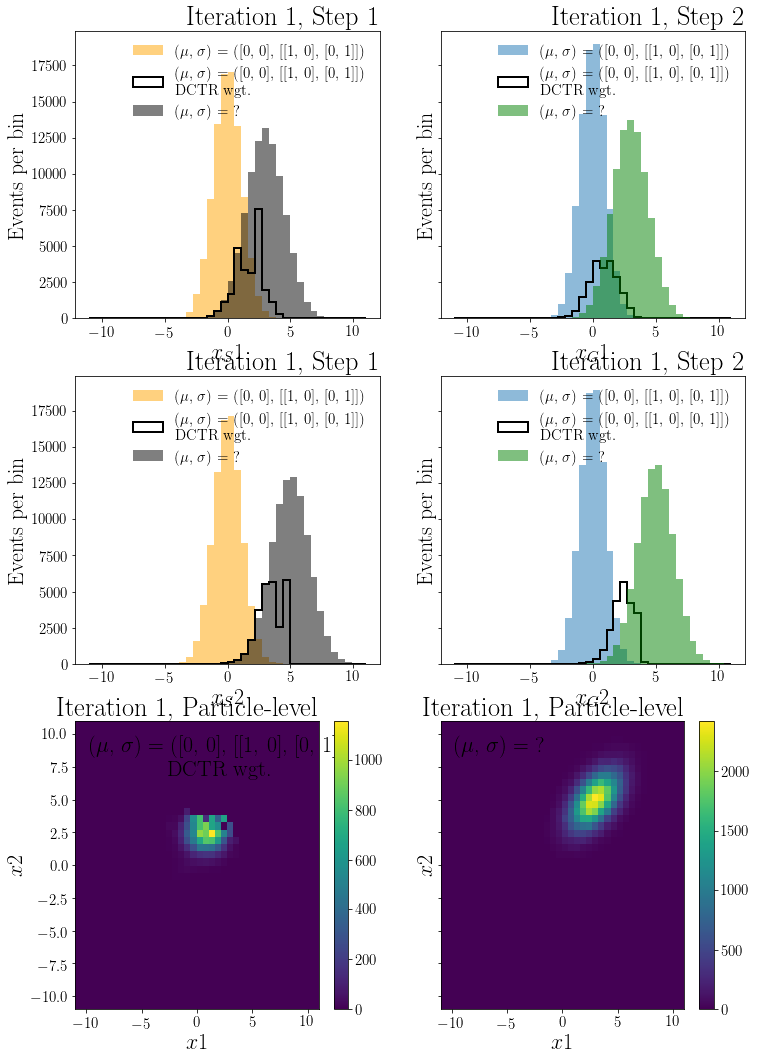

<Figure size 864x288 with 0 Axes>

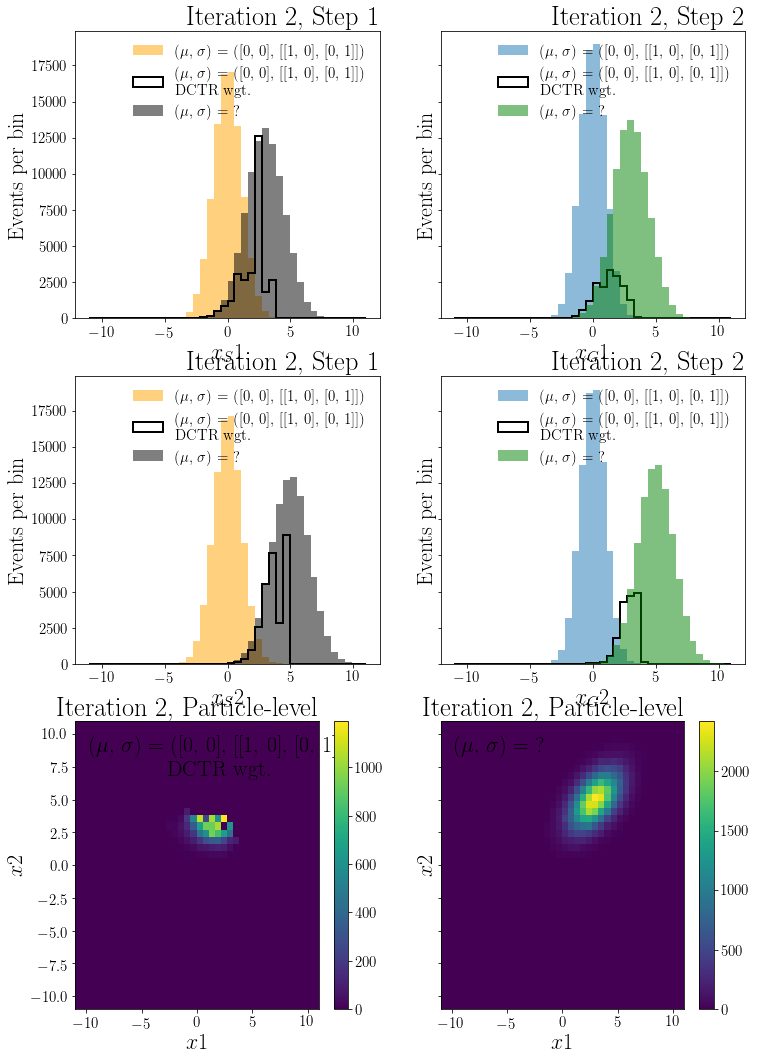

<Figure size 864x288 with 0 Axes>

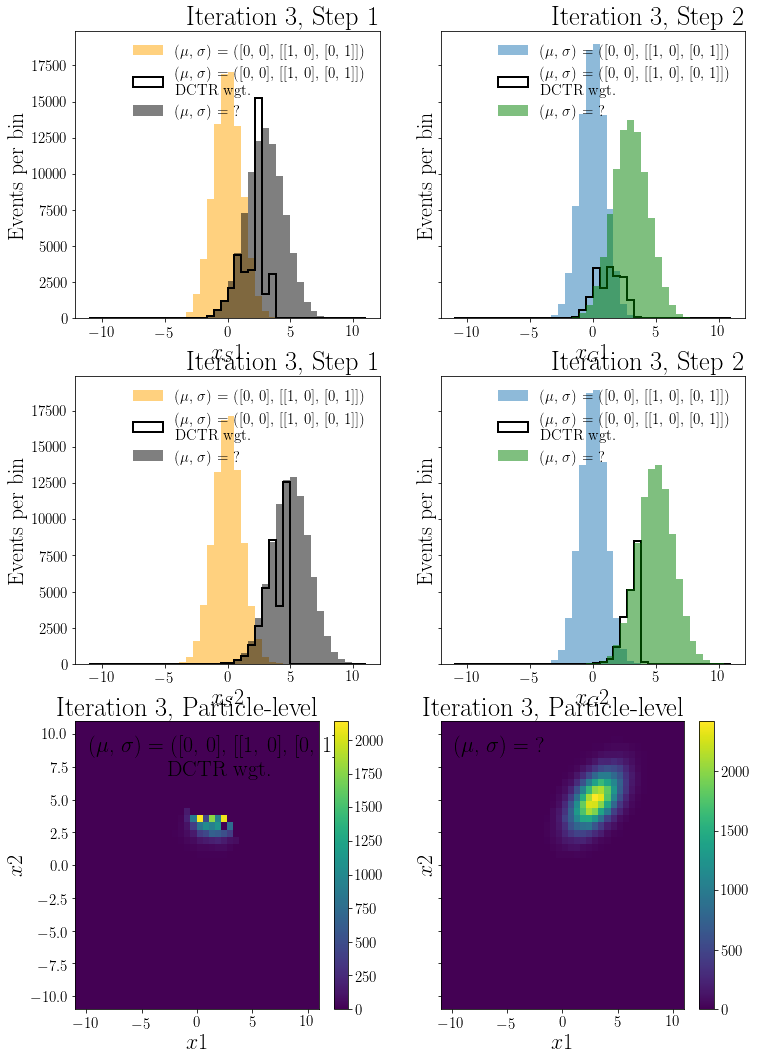

<Figure size 864x288 with 0 Axes>

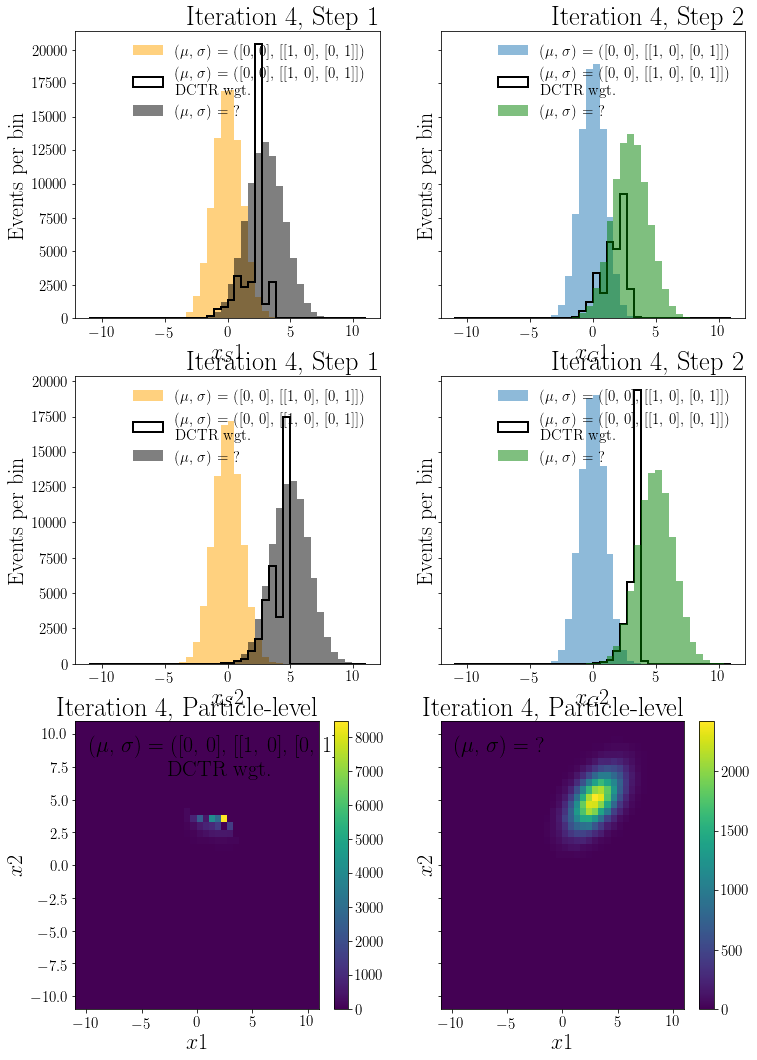

In [25]:
bins = np.linspace(-11, 11, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(3,
                       2,
                       figsize=(12, 18),
                       #constrained_layout=True,
                       sharey='row')

for ix in range(2):
        #Detector-level
        ax[ix,0].set_title("Initialization, Detector-level",style='italic',loc='right')
        hist0 = ax[ix,0].hist(theta0_S[theta0_S[:,0]!=dummyval][:,ix], # initial MC reco 
                        bins=bins,
                        color="orange",
                        label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                        **plot_style_2)

        _,_,_= ax[ix,0].hist(
            theta0_S[theta0_S[:,0]!=dummyval][:,ix], # MC reco after reweight
            bins=bins,
            label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
            **plot_style_1)
        _,_,_= ax[ix,0].hist(theta_unknown_S[theta_unknown_S[:,0]!=dummyval][:,ix], # data reco
                        bins=bins,
                        label=r'($\mu$, $\sigma$) = ?',
                        #weights=weights[i, 0, :][theta_unknown_S[:,0]!=dummyval],
                        **plot_style_2,
                        color="black")
        ax[ix,0].legend(frameon=False)
        ax[ix,0].set_xlabel(r"$x_S$"+str(ix+1))
        ax[ix,0].set_ylabel("Events per bin")

        #Particle-level
        ax[ix,1].set_title("Initialization, Particle-level",style='italic',loc='right')
        _,_,_=ax[ix,1].hist(theta0_G[theta0_G[:,0]!=dummyval][:,ix], # initial MC truth
                        bins=bins,
                        label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                        **plot_style_2)

        _,_,_= ax[ix,1].hist(
            theta0_G[theta0_G[:,0]!=dummyval][:,ix],
            bins=bins,
            label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param), # MC truth after reweight
            **plot_style_1)
        _,_,_= ax[ix,1].hist(theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,ix], # real data truth
                        bins=bins,
                        label=r'($\mu$, $\sigma$) = ?',
                        **plot_style_2,
                        color="green")
        ax[ix,1].legend(frameon=False)
        ax[ix,1].set_xlabel(r"$x_G$"+str(ix+1))
        ax[ix,1].set_ylabel("Events per bin")

ax[2,0].set_title("Initialization, Particle-level",style='italic',loc='right')
ax[2,0].set_xlabel('$x1$')
ax[2,0].set_ylabel('$x2$')
h5 = ax[2,0].hist2d(theta0_G[theta0_G[:,0]!=dummyval][:,0], theta0_G[theta0_G[:,0]!=dummyval][:,1] , bins=(bins,bins),label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param)) # MC truth after reweight
fig.colorbar(h5[3],ax=ax[2,0])
legend = ax[2,0].legend(
    title='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[2,1].set_title("Initialization, Particle-level",style='italic',loc='right')
ax[2,1].set_xlabel('$x1$')
ax[2,1].set_ylabel('$x2$')
h6 = ax[2,1].hist2d(theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,0], theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,1] , bins=(bins,bins),label=r'($\mu$, $\sigma$) = ?') # real data truth
fig.colorbar(h6[3],ax=ax[2,1])
legend = ax[2,1].legend(
    title=r'($\mu$, $\sigma$) = ?',
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.tight_layout()


#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 4
                        ))
    
    fig, ax = plt.subplots(3,2,
                       figsize=(12, 18),
                       #constrained_layout=True,
                       sharey='row')
    
    for ix in range(2):
            #Detector-level
            ax[ix,0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
            hist0 = ax[ix,0].hist(theta0_S[theta0_S[:,0]!=dummyval][:,ix], # initial MC reco 
                            bins=bins,
                            color="orange",
                            label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                            **plot_style_2)

            _,_,_= ax[ix,0].hist(
                theta0_S[theta0_S[:,0]!=dummyval][:,ix], # MC reco after reweight 
                bins=bins,
                label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
                weights=weights[i, 0, :][theta0_S[:,0]!=dummyval],
                **plot_style_1)
            _,_,_= ax[ix,0].hist(theta_unknown_S[theta_unknown_S[:,0]!=dummyval][:,ix], # real data reco
                            bins=bins,
                            label=r'($\mu$, $\sigma$) = ?',
                            #weights=weights[i, 0, :][theta_unknown_S[:,0]!=dummyval],
                            **plot_style_2,
                            color="black")
            ax[ix,0].legend(frameon=False)
            ax[ix,0].set_xlabel(r"$x_S$"+str(ix+1))
            ax[ix,0].set_ylabel("Events per bin")

            #Particle-level
            ax[ix,1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
            _,_,_=ax[ix,1].hist(theta0_G[theta0_G[:,0]!=dummyval][:,ix], # initial MC truth 
                            bins=bins,
                            label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                            **plot_style_2)

            _,_,_= ax[ix,1].hist(
                theta0_G[theta0_G[:,0]!=dummyval][:,ix],
                bins=bins,
                label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param), # MC truth after reweight
                weights=weights[i, 1, :][theta0_G[:,0]!=dummyval],
                **plot_style_1)
            _,_,_= ax[ix,1].hist(theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,ix], # real data truth
                            bins=bins,
                            label=r'($\mu$, $\sigma$) = ?',
                            **plot_style_2,
                            color="green")
            ax[ix,1].legend(frameon=False)
            ax[ix,1].set_xlabel(r"$x_G$"+str(ix+1))
            ax[ix,1].set_ylabel("Events per bin")

    ax[2,0].set_title("Iteration " +str(i+1)+ ", Particle-level",style='italic',loc='right')
    ax[2,0].set_xlabel('$x1$')
    ax[2,0].set_ylabel('$x2$')
    h5 = ax[2,0].hist2d(theta0_G[theta0_G[:,0]!=dummyval][:,0], theta0_G[theta0_G[:,0]!=dummyval][:,1], # MC truth after reweight
                        bins=(bins,bins),label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),weights=weights[i, 1, :][theta0_G[:,0]!=dummyval])
    fig.colorbar(h5[3],ax=ax[2,0])
    legend = ax[2,0].legend(
        title='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        loc='upper left',
        frameon=False)
    plt.setp(legend.get_title(), multialignment='center')

    ax[2,1].set_title("Iteration " +str(i+1)+ ", Particle-level",style='italic',loc='right')
    ax[2,1].set_xlabel('$x1$')
    ax[2,1].set_ylabel('$x2$')
    h6 = ax[2,1].hist2d(theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,0], theta_unknown_G[theta_unknown_G[:,0]!=dummyval][:,1] , bins=(bins,bins),label=r'($\mu$, $\sigma$) = ?') # real data truth
    fig.colorbar(h6[3],ax=ax[2,1])
    legend = ax[2,1].legend(
        title=r'($\mu$, $\sigma$) = ?',
        loc='upper left',
        frameon=False)
    plt.setp(legend.get_title(), multialignment='center')